# Load candidates

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/anhphantq/otto')

In [2]:
CACHE = '/home/anhphantq/cache_train'
import os

import pickle
from tqdm import tqdm
train_data = []
num_cands = []

with open(CACHE + '/metadata', 'rb') as f:
  metadata = pickle.load(f)

num_frags = metadata['num_frags']


for i in tqdm(range(num_frags)):
    with open(CACHE + f'/train_data_{i}', 'rb') as f:
      data = pickle.load(f)
      train_data.extend(data[0])
      num_cands.extend(data[1])






100%|██████████| 180/180 [00:15<00:00, 11.79it/s]


In [3]:
import numpy as np
train_data = np.concatenate(train_data)
num_cands = np.concatenate(num_cands)
train_data.shape, num_cands.shape

((39501303, 53), (13167101,))

In [4]:
from xgb_utils import create_data

In [5]:
train_data.shape

(39501303, 53)

In [6]:
import pandas as pd 

candidates = create_data(train_data, infer = False)


In [7]:
del train_data

In [8]:
candidates


,user,item,type,cofitness_cosub,cofitness_time_decay,num_appearance,type_weight,coclick,cocart,coorder,...,prod_num_appearance_coorder,prod_type_weight_coclick,prod_type_weight_cocart,prod_type_weight_coorder,prod_coclick_cocart,prod_coclick_coorder,prod_cocart_coorder,clicks,carts,orders
0,11279499,411416,0,328.849018,174.440922,49.0,8160.0,680.0,0.0,0.0,...,0.0,5548800.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,11279499,1182721,0,239.811228,131.292106,32.0,7824.0,612.0,40.0,0.0,...,0.0,4788288.0,312960.0,0.0,24480.0,0.0,0.0,1,0,0
2,11279499,942778,0,184.842802,99.245795,27.0,5592.0,430.0,36.0,0.0,...,0.0,2404560.0,201312.0,0.0,15480.0,0.0,0.0,1,0,0
3,11279499,1546170,0,153.828122,83.073927,30.0,4908.0,409.0,0.0,0.0,...,0.0,2007372.0,0.0,0.0,0.0,0.0,0.0,1,0,0
4,11279499,402770,0,148.679350,78.637721,23.0,4944.0,402.0,10.0,0.0,...,0.0,1987488.0,49440.0,0.0,4020.0,0.0,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39501298,11300953,1113091,2,0.574634,0.316351,5.0,20.0,20.0,0.0,0.0,...,0.0,400.0,0.0,0.0,0.0,0.0,0.0,0,0,1
39501299,11300953,1410850,2,0.573818,0.273191,7.0,30.0,30.0,0.0,0.0,...,0.0,900.0,0.0,0.0,0.0,0.0,0.0,0,0,1
39501300,11300953,523350,2,0.623308,0.342938,2.0,10.0,10.0,0.0,0.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0,0,1
39501301,11300953,988152,2,0.541425,0.299625,3.0,15.0,15.0,0.0,0.0,...,0.0,225.0,0.0,0.0,0.0,0.0,0.0,0,0,1


# Train params

In [9]:
PARAMS = {
    'max_depth' : 5,
    'eta': 1,
    
}
N_SPLITS = 3
NUM_TREE = 100
MODEL_PATH = '/home/anhphantq/xgboost'
VERSION = '3'

# Train for each type

In [10]:
from xgb_utils import get_len_group

In [11]:
import pandas as pd 
import numpy as np
tar = pd.read_parquet('/home/anhphantq/otto/splitted_data/test_labels.parquet')
tar = tar.loc[(tar['session'] <= candidates['user'].max()) & (tar['session'] >= candidates['user'].min()) ]
aids = tar.ground_truth.explode().astype('int32').rename('item')
tar = tar[['session', 'type']].rename({'session':'user'},axis=1)
tar = tar.merge(aids, left_index=True, right_index=True, how='left')
tar['type'] = tar['type'].apply(lambda x: 0 if x == 'clicks' else 1 if x == 'carts' else 2)
tar['label'] = 1

In [12]:
tar

,user,type,item,label
113400,11188590,0,607328,1
113401,11188591,0,557157,1
113402,11188591,1,1597320,1
113402,11188591,1,1236555,1
113402,11188591,1,970284,1
...,...,...,...,...
448302,11458773,0,1372721,1
448303,11458774,0,167699,1
448304,11458775,0,885450,1
448305,11458776,0,364710,1


In [13]:
import xgboost as xgb
from sklearn.model_selection import GroupKFold
import os
def train(tar_, candidates_, num_cands_, t, id_type):
  
  name = f'/{t}_only_'
  try:
    shutil.rmtree(MODEL_PATH + name + VERSION)
  except:
    pass
  else:
    print('remove all version')
  
  tar = tar_[tar_['type'] == id_type].copy()
  idx = candidates_['type'] == id_type
  candidates = candidates_[idx].copy()
  
  candidates['user_type'] = candidates['user'] * 10 + candidates['type']
  tar['user_type'] = tar['user'] * 10 + tar['type']
  del tar['type'], tar['user']
  candidates = candidates.merge(tar,on=['user_type','item'],how='left').fillna(0)
  candidates['label'] = candidates['label'].values.astype(np.int16)
  
  del candidates['type'], candidates['user_type']

  skf = GroupKFold(n_splits=N_SPLITS)
  for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates['label'], groups=candidates['user'] )):

      X_train = candidates.iloc[train_idx, 2 : -1]
      y_train = candidates.iloc[train_idx, -1]
      X_valid = candidates.iloc[valid_idx, 2 : -1]
      y_valid = candidates.iloc[valid_idx, -1]

      dtrain = xgb.DMatrix(X_train, y_train, nthread = os.cpu_count() ) 
      dtrain.set_group(get_len_group(train_idx, num_cands))
      dvalid = xgb.DMatrix(X_valid, y_valid, nthread = os.cpu_count() ) 
      dvalid.set_group(get_len_group(valid_idx, num_cands))
      
      xgb_parms = {'objective':'rank:pairwise', 'nthread' : os.cpu_count()
      , **PARAMS}
      model = xgb.train(xgb_parms, 
          dtrain=dtrain,
          evals=[(dtrain,'train'),(dvalid,'valid')],
          num_boost_round=NUM_TREE,
          early_stopping_rounds= 5,    
          verbose_eval=1)
      try:
        os.mkdir(MODEL_PATH + name + VERSION)
      except:
        pass
      model.save_model(MODEL_PATH + name + VERSION + f'/XGB_fold{fold}.xgb')
      xgb.plot_importance(model)

[0]	train-map:0.81796	valid-map:0.82000
[1]	train-map:0.81816	valid-map:0.82022
[2]	train-map:0.81845	valid-map:0.82043
[3]	train-map:0.81883	valid-map:0.82068
[4]	train-map:0.81910	valid-map:0.82080
[5]	train-map:0.81933	valid-map:0.82112
[6]	train-map:0.81942	valid-map:0.82110
[7]	train-map:0.81962	valid-map:0.82111
[8]	train-map:0.81978	valid-map:0.82109
[9]	train-map:0.81991	valid-map:0.82131
[10]	train-map:0.82026	valid-map:0.82149
[11]	train-map:0.82031	valid-map:0.82168
[12]	train-map:0.82038	valid-map:0.82172
[13]	train-map:0.82052	valid-map:0.82179
[14]	train-map:0.82059	valid-map:0.82171
[15]	train-map:0.82063	valid-map:0.82181
[16]	train-map:0.82067	valid-map:0.82181
[17]	train-map:0.82081	valid-map:0.82176
[18]	train-map:0.82086	valid-map:0.82166
[19]	train-map:0.82105	valid-map:0.82174
[20]	train-map:0.82133	valid-map:0.82175
[0]	train-map:0.81903	valid-map:0.81960
[1]	train-map:0.81910	valid-map:0.81954
[2]	train-map:0.81912	valid-map:0.81952
[3]	train-map:0.81942	valid-m

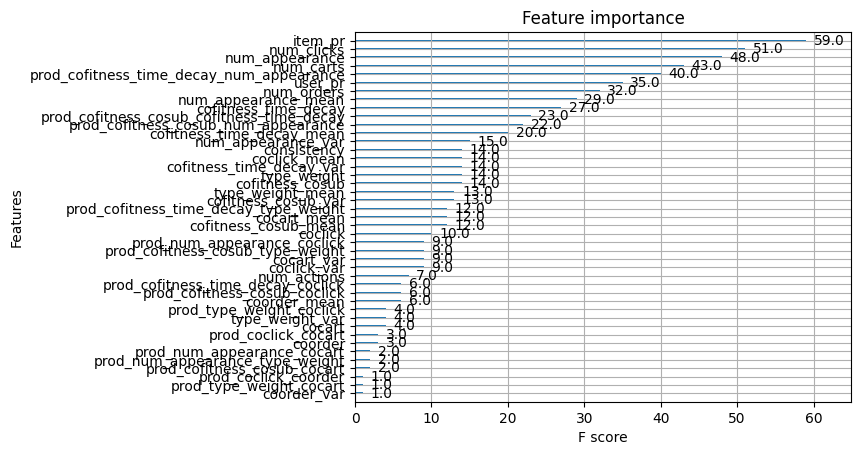

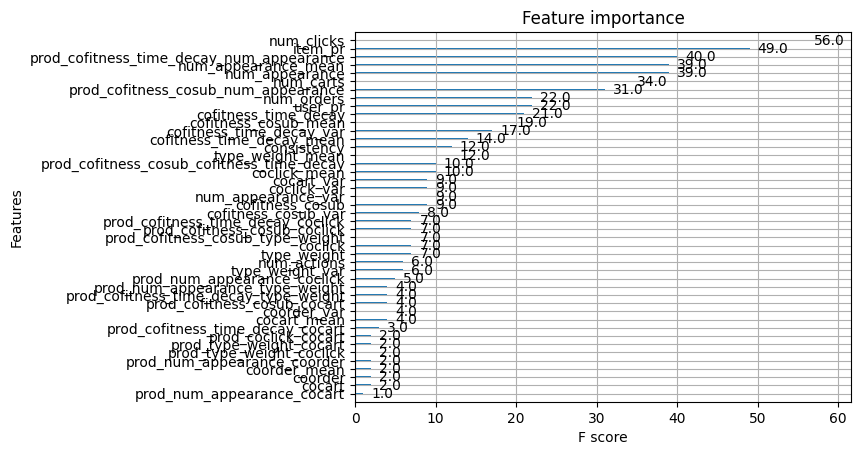

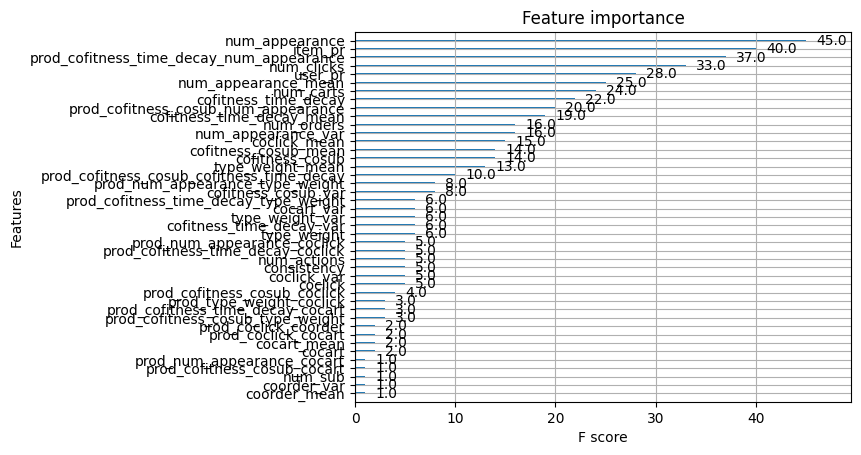

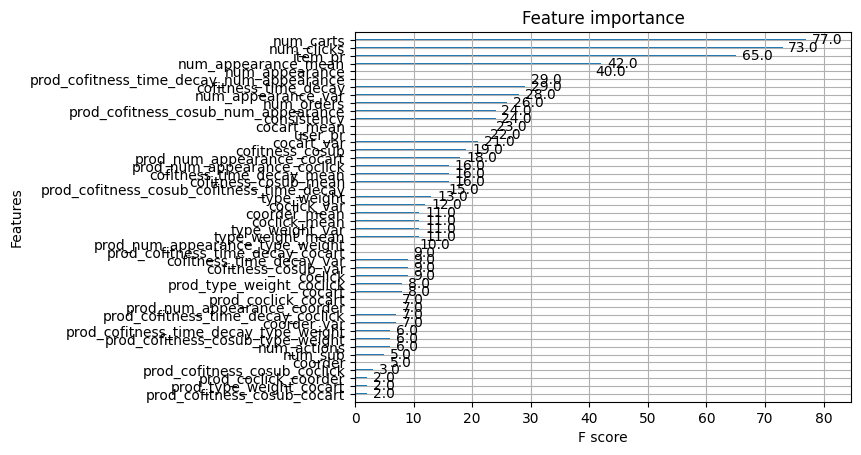

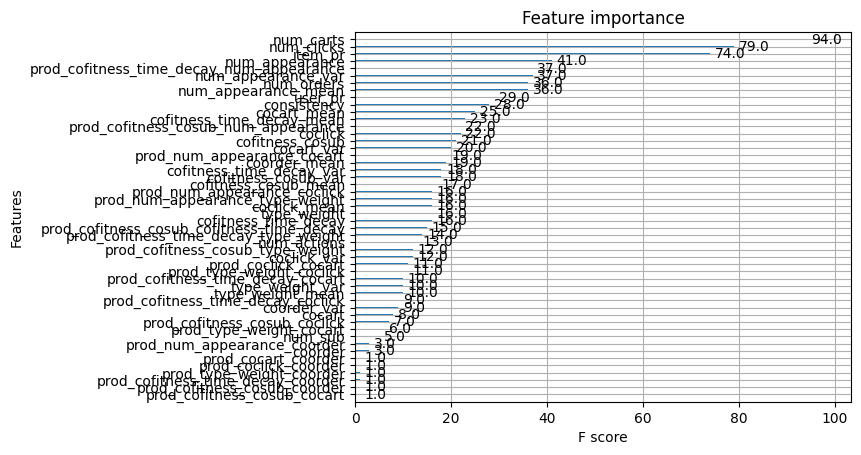

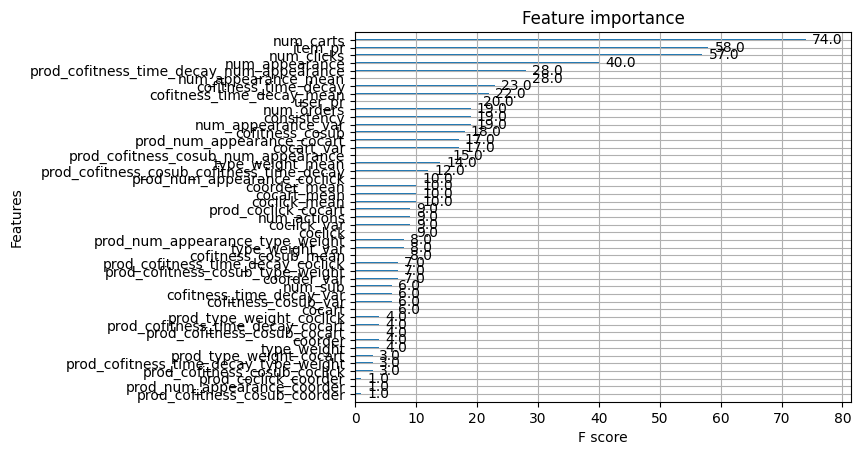

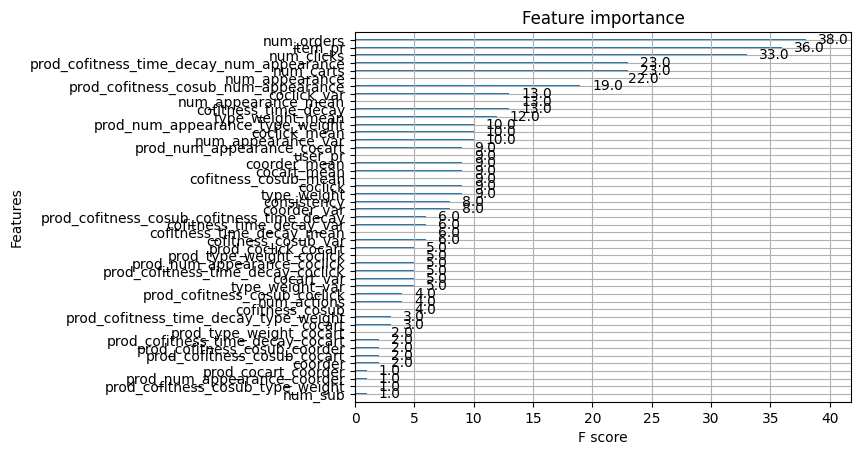

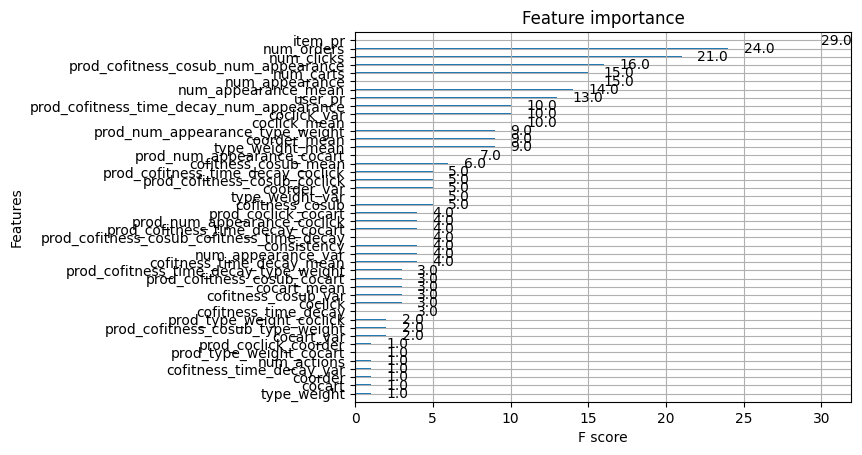

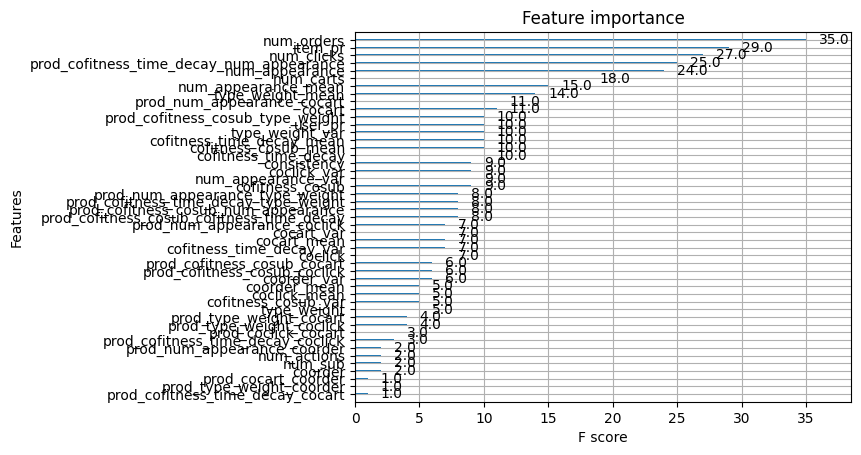

In [14]:
for id_type, t in enumerate(['clicks', 'carts', 'orders']):
  train(tar, candidates, num_cands, t, id_type)